## Preprocessing

In [1]:
from nilearn import plotting
%matplotlib inline
import os
import json
from nipype.interfaces import fsl 
from nipype.interfaces import spm
from nipype.interfaces.spm import (Realign, SliceTiming, Coregister,  NewSegment,  Normalize12, Smooth)
from nipype.interfaces import matlab as mlab
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms import rapidart as ra
from nipype.interfaces.utility import IdentityInterface
from nipype import Workflow, Node

In [2]:
spm.SPMCommand.set_mlab_paths(paths=os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')), matlab_cmd='/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB -nodesktop -nosplash')

stty: 'standard input': Inappropriate ioctl for device


In [3]:
mlab.MatlabCommand.set_default_matlab_cmd("/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB  -nodesktop -nosplash")
mlab.MatlabCommand.set_default_paths(os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')))

In [4]:
# spm.SPMCommand().version

In [5]:
fsl.FSLCommand.set_default_output_type('NIFTI')

In [6]:
base_dir = os.path.join(os.environ['HOME'], 'spmbasics/data/')

In [7]:
experiment_dir = os.path.join(base_dir, 'output')
output_dir = 'nipype_d'
working_dir = 'workingdir'

# list of subject identifiers
subject_id = ['01']

task_id = ['auditory']

# task_id = ['auditory']
# TR of functional images
with open(os.path.join(base_dir, 'MoAEpilot_raw/task-auditory_bold.json'), 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Smoothing width used during preprocessing
fwhm = [6]

In [8]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_id),
                        ('task_name', task_id)]
# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = os.path.join( base_dir, 'MoAEpilot_raw/', 'sub-{subject_id}', 'anat',  'sub-{subject_id}_T1w.nii' )
func_file = os.path.join( base_dir, 'MoAEpilot_raw/', 'sub-{subject_id}', 'func',
                'sub-{subject_id}_task-{task_name}_bold.nii')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory=base_dir),
                   name="selectfiles")

# Datasink - creates output folder for the needed outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

In [9]:
realigner = Node(interface=Realign(), name='realign')
realigner.inputs.register_to_mean = True
realigner.inputs.fwhm = 5
realigner.inputs.interp = 2
realigner.inputs.quality = 0.9
realigner.inputs.separation = 4
realigner.inputs.wrap = [0, 0, 0]
realigner.inputs.write_which = [2, 1]
realigner.inputs.write_interp = 4 
realigner.inputs.write_wrap = [0, 0, 0]
realigner.inputs.write_mask = True
realigner.inputs.jobtype = 'estwrite'
realigner.inputs.out_prefix = 'r'

In [10]:
slicetiming = Node(interface=SliceTiming(), name = 'slicetiming')
slicetiming.inputs.num_slices = 64
slicetiming.inputs.time_repetition = 7.
slicetiming.inputs.time_acquisition = 6.8906
slicetiming.inputs.slice_order = list(range(64,0,-1))
slicetiming.inputs.ref_slice = 32
slicetiming.inputs.out_prefix = 'a'

https://github.com/nipy/nipype/issues/2697 check this

In [11]:
coregister = Node(Coregister(), name="coregister")
coregister.inputs.jobtype = 'estimate'
coregister.inputs.cost_function = 'nmi'
coregister.inputs.fwhm = [7.0, 7.0]
coregister.inputs.separation = [4.0, 2.0]
coregister.inputs.tolerance = [0.02, 0.02, 0.02, 0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001]
coregister.inputs.out_prefix = 'c'

In [12]:
tpm_path = os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/tpm/', 'TPM.nii'))

In [13]:
segment =  Node(NewSegment(), name="newsegment")
segment.inputs.affine_regularization = 'mni'
segment.inputs.channel_info = (0.001, 60, (False, True)) #save bias field map or save bias corrected map
tissue1 = ((tpm_path, 1), 1, (True, False), (False, False))
tissue2 = ((tpm_path, 2), 1, (True, False), (False, False))
tissue3 = ((tpm_path, 3), 2, (True, False), (False, False))
tissue4 = ((tpm_path, 4), 3, (True, False), (False, False))
tissue5 = ((tpm_path, 5), 4, (True, False), (False, False))
tissue6 = ((tpm_path, 6), 2, (False, False), (False, False))
segment.inputs.tissues = [tissue1, tissue2, tissue3, tissue4, tissue5, tissue6]
segment.inputs.warping_regularization = [0, 0.001, 0.5, 0.05, 0.2]
segment.inputs.sampling_distance = 3
segment.inputs.write_deformation_fields = [False, True] 

stty: 'standard input': Inappropriate ioctl for device


In [19]:
import nibabel as nb

In [20]:
deformationnipype = nb.load('/home/matay/spmbasics/data/output/nipype_d/dissect0s_mni_ysubmsubdifferent/_subject_id_01_task_name_auditory/y_sub-01_T1w.nii')

In [32]:
coreg = nb.load('/home/matay/spmbasics/data/output/nipype_d/dissect0s_mni_ysubmsubdifferent/_subject_id_01_task_name_auditory/sub-01_T1w.nii')

In [33]:
anat = deformationnipype = nb.load('/home/matay/spmbasics/data/output/nipype_d/dissect0s_mni_ysubmsubdifferent/sub-01_T1w.nii')

In [34]:
print(coreg)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (256, 256, 54)
affine:
[[-9.99964237e-01  6.79600239e-03  1.51562095e-02  1.21845886e+02]
 [ 6.72775507e-03  9.99887466e-01 -4.02293205e-02 -1.50012634e+02]
 [ 5.14262915e-03  1.33752823e-02  2.99969196e+00 -7.28643875e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='>'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 256  54   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         1.0000001  1.         3.         0.         0.
  0.         0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
ca

In [35]:
print(anat)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (256, 256, 54)
affine:
[[-9.99964595e-01  6.76572323e-03  1.50594115e-02  1.21850769e+02]
 [ 6.69789314e-03  9.99887645e-01 -4.02288437e-02 -1.50009827e+02]
 [ 5.10996580e-03  1.33755207e-02  2.99969244e+00 -7.28613281e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='>'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 256  54   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         1.0000001  1.         3.         0.         0.
  0.         0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
ca

In [36]:
mse_anat= mean_squared_error(coreg.affine, coreg.affine)

In [24]:
print(deformationnipype )


<class 'nibabel.nifti1.Nifti1Image'>
data shape (121, 145, 121, 1, 3)
affine:
[[  -1.5    0.     0.    90. ]
 [   0.     1.5    0.  -126. ]
 [   0.     0.     1.5  -72. ]
 [   0.     0.     0.     1. ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  5 121 145 121   1   3   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.   1.5  1.5  1.5  0.   0.   0.   0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'Deformation'
aux_file        : 

In [21]:
print(deformationnipype.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  5 121 145 121   1   3   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.   1.5  1.5  1.5  0.   0.   0.   0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'Deformation'
aux_file        : b''
qform_code      : aligned
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 90.0
qoffset_y       : -126.0
qoffset_z       : -72.0
srow_x          : [-

In [22]:
deformationori = nb.load('/home/matay/spmbasics/data/MoAEpilot_rawz/sub-01/anat/y_sub-01_T1w.nii')

In [46]:
print(deformationori.affine[:, : ])

[[  -1.5    0.     0.    90. ]
 [   0.     1.5    0.  -126. ]
 [   0.     0.     1.5  -72. ]
 [   0.     0.     0.     1. ]]


In [23]:
print(deformationori.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  5 121 145 121   1   3   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.   1.5  1.5  1.5  0.   0.   0.   0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'Deformation'
aux_file        : b''
qform_code      : aligned
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 90.0
qoffset_y       : -126.0
qoffset_z       : -72.0
srow_x          : [-

In [26]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

In [50]:
print(deformationnipype.affine)

[[-9.99964595e-01  6.76572323e-03  1.50594115e-02  1.21850769e+02]
 [ 6.69789314e-03  9.99887645e-01 -4.02288437e-02 -1.50009827e+02]
 [ 5.10996580e-03  1.33755207e-02  2.99969244e+00 -7.28613281e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [29]:
print(deformationnipype.header.get_data_dtype())

float32


In [30]:
mse_none = mean_squared_error(deformationnipype.affine, deformationori.affine)



In [31]:
print(mse_none)

0.0


In [48]:
ssim_none = ssim(deformationnipype.affine[0, :], deformationori.affine[0, :], data_range=deformationnipype.affine[0, :].max() - deformationori.affine[0, :].min())

ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.

In [14]:
normalize = Node(Normalize12(), name="normalize") #old normalize now
normalize.inputs.jobtype = 'write'
normalize.inputs.write_bounding_box =  [[-78, -112, -70], [78, 76, 85]]
normalize.inputs.write_voxel_sizes = [3, 3, 3]
normalize.inputs.write_interp = 4
normalize.inputs.out_prefix = 'w'

In [15]:
smooth = Node(Smooth(), name="smooth")
smooth.inputs.fwhm = [6, 6, 6]
smooth.inputs.data_type = 0
smooth.inputs.implicit_masking = False
smooth.inputs.out_prefix = 's'

In [16]:
art = Node(ra.ArtifactDetect(), name="art")
art.inputs.use_differences = [True, False]
art.inputs.use_norm = True
art.inputs.norm_threshold = 1
art.inputs.zintensity_threshold = 3
art.inputs.mask_type = 'spm_global'
art.inputs.parameter_source = 'SPM'
art.inputs.plot_type='svg'

In [17]:
def get_vox_dims(volume):
    import nibabel as nb
    if isinstance(volume, list):
        volume = volume[0]
    nii = nb.load(volume)
    hdr = nii.header
    voxdims = hdr.get_zooms()
    return [float(voxdims[0]), float(voxdims[1]), float(voxdims[2])]

In [18]:
dissect0s = Workflow(name='nipype_block_d0s')
dissect0s.base_dir = os.path.join(experiment_dir, working_dir)

In [32]:
dissect0s.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                              ('task_name', 'task_name')]),
                 (selectfiles, realigner, [('func', 'in_files')]),
                 (selectfiles, datasink, [('func', 'dissect0s.@func'),
                                          ('anat', 'dissect0s.@anat')]),  
                 (realigner, datasink, [('realignment_parameters', 'dissect0s.@realignement_parameters'),
                                        ('realigned_files', 'dissect0s.@realigned_files'),
                                        ('mean_image', 'dissect0s.@mean_image')]),
                 (realigner, slicetiming, [('realigned_files', 'in_files')]),  
                 (slicetiming, datasink, [('timecorrected_files', 'dissect0s.@timecorrected_files')]),
                 (realigner, coregister, [('mean_image', 'target')]),
                 (selectfiles, coregister, [('anat', 'source')]), 
                 (coregister, datasink, [('coregistered_source', 'dissect0s.@coregisered_source')]),
                 (coregister, segment, [('coregistered_source', 'channel_files')]),
                 (segment, datasink, [('bias_corrected_images', 'dissect0s.@bias_corrected_images'),
                                      ('transformation_mat', 'dissect0s.@transformation_mat'),
                                      ('native_class_images', 'dissect0s.@native_class_images'),
                                      ('forward_deformation_field', 'dissect0s.@forward_deformation_field')])   
])

OSError: Duplicate node name "selectfiles" found.

240524-12:00:50,909 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/nipype_block_d0s/colored_block.png (graph2use=colored, simple_form=True).


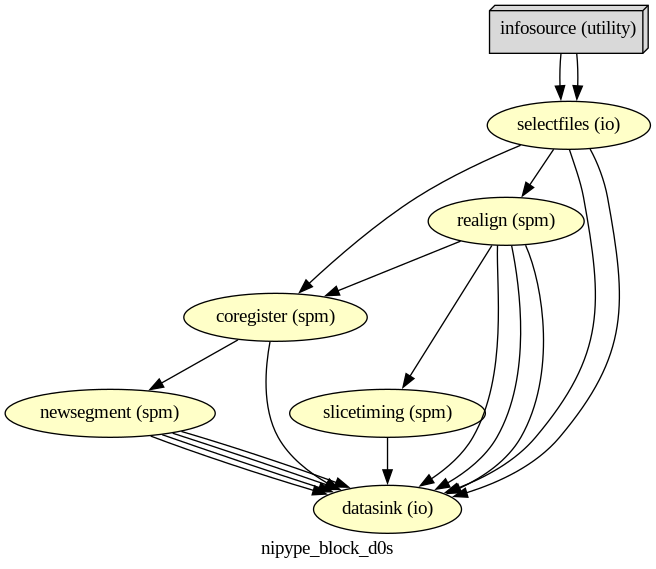

In [17]:
# Create 1st-level analysis output graph
dissect0s.write_graph(graph2use='colored', format='png', dotfilename='colored_block.dot', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(dissect0s.base_dir, 'nipype_block_d0s', 'colored_block.png'))

In [18]:
dissect0s.run('MultiProc', plugin_args={'n_procs': 4})

240524-12:00:53,277 nipype.workflow INFO:
	 Workflow nipype_block_d0s settings: ['check', 'execution', 'logging', 'monitoring']
240524-12:00:53,283 nipype.workflow INFO:
	 Running in parallel.
240524-12:00:53,284 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240524-12:00:53,376 nipype.workflow INFO:
	 [Node] Setting-up "nipype_block_d0s.selectfiles" in "/home/matay/spmbasics/data/output/workingdir/nipype_block_d0s/_subject_id_01_task_name_auditory/selectfiles".
240524-12:00:53,383 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
240524-12:00:53,386 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.000963s.
240524-12:00:55,286 nipype.workflow INFO:
	 [Job 0] Completed (nipype_block_d0s.selectfiles).
240524-12:00:55,289 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240524-12

stty: 'standard input': Inappropriate ioctl for device


240524-12:01:58,494 nipype.workflow INFO:
	 [Node] Finished "newsegment", elapsed time 52.336581s.


stty: 'standard input': Inappropriate ioctl for device


240524-12:01:59,351 nipype.workflow INFO:
	 [Job 4] Completed (nipype_block_d0s.newsegment).
240524-12:01:59,355 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240524-12:01:59,416 nipype.workflow INFO:
	 [Node] Outdated cache found for "nipype_block_d0s.datasink".
240524-12:01:59,418 nipype.workflow INFO:
	 [Node] Setting-up "nipype_block_d0s.datasink" in "/home/matay/spmbasics/data/output/workingdir/nipype_block_d0s/_subject_id_01_task_name_auditory/datasink".
240524-12:01:59,420 nipype.workflow INFO:
	 [Node] Outdated cache found for "nipype_block_d0s.datasink".
240524-12:01:59,423 nipype.workflow INFO:
	 [Node] Executing "datasink" <nipype.interfaces.io.DataSink>
240524-12:01:59,427 nipype.workflow INFO:
	 [Node] Finished "datasink", elapsed time 0.001449s.
240524-12:02:01,354 nipype.workflow INFO:
	 [Job 5] Completed (nipype_block_d0s.datasink).
240524-12:02:01,359 nipype.workflow INFO:
	 [MultiProc] Runni

In [18]:
block_preprocess = Workflow(name='nipype_block_preprocess')
block_preprocess.base_dir = os.path.join(experiment_dir, working_dir)

In [19]:
block_preprocess.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name')]),
                 (selectfiles, realigner, [('func', 'in_files')]),
                 (selectfiles, datasink, [('func', 'block_preprocess.@func'),
                                          ('anat', 'block_preprocess.@anat')]),  
                 (realigner, datasink, [('realignment_parameters', 'block_preprocess.@realignement_parameters'),
                                        ('realigned_files', 'block_preprocess.@realigned_files'),
                                        ('mean_image', 'block_preprocess.@mean_image'),
                                        ('modified_in_files', 'block_preprocess.@modified_in_files')]),
                 (realigner, slicetiming, [('realigned_files', 'in_files')]),  
                 (slicetiming, datasink, [('timecorrected_files', 'block_preprocess.@timecorrected_files')]),
                 (realigner, coregister, [('mean_image', 'target')]), # ('realigned_files', 'apply_to_files')
                 (selectfiles, coregister, [('anat', 'source')]), 
                 (coregister, datasink, [('coregistered_source', 'block_preprocess.@coregisered_source'),
                                         ('coregistered_files', 'block_preprocess.@coregistered_files')]),
                 (coregister, segment, [('coregistered_source', 'channel_files')]),
                 (segment, datasink, [('bias_corrected_images', 'block_preprocess.@bias_corrected_images'), 
                                      ('transformation_mat', 'block_preprocess.@transformation_mat'),
                                      ('native_class_images', 'block_preprocess.@native_class_images'),
                                      ('forward_deformation_field', 'block_preprocess.@forward_deformation_field')]),
                 (segment, normalize, [('forward_deformation_field', 'deformation_file')]),
                 (slicetiming, normalize, [('timecorrected_files', 'apply_to_files'),
                                          (('timecorrected_files', get_vox_dims), 'write_voxel_sizes')]),
                 (normalize, datasink, [('normalized_files', 'block_preprocess.@normalized_files')]),
                 (normalize, smooth, [('normalized_files', 'in_files')]),
                 (smooth, datasink, [('smoothed_files', 'block_preprocess.@smoothed_files')]),
                 # (realigner, art, [('realignment_parameters', 'realignment_parameters')]),
                 # (normalize, art, [('normalized_files', 'realigned_files')]),
                 #(art, datasink, [('outlier_files', 'block_preprocess.@outlier_files'),
                                  #('plot_files', 'block_preprocess.@plot_files')]),
])

240523-17:17:10,388 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/colored_block.png (graph2use=colored, simple_form=True).


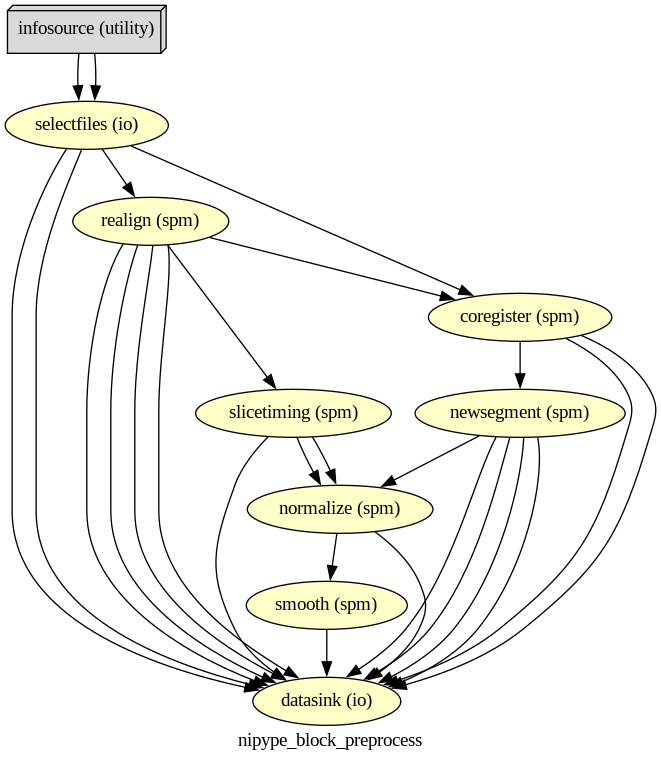

In [21]:
# Create 1st-level analysis output graph
block_preprocess.write_graph(graph2use='colored', format='png', dotfilename='colored_block.dot', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(block_preprocess.base_dir, 'nipype_block_preprocess', 'colored_block.png'))

In [22]:
# Create 1st-level analysis output graph
block_preprocess.write_graph(graph2use='flat', format='png', dotfilename='flat_block.dot', simple_form=True)

240523-17:17:19,674 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/flat_block.png (graph2use=flat, simple_form=True).


'/home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/flat_block.png'

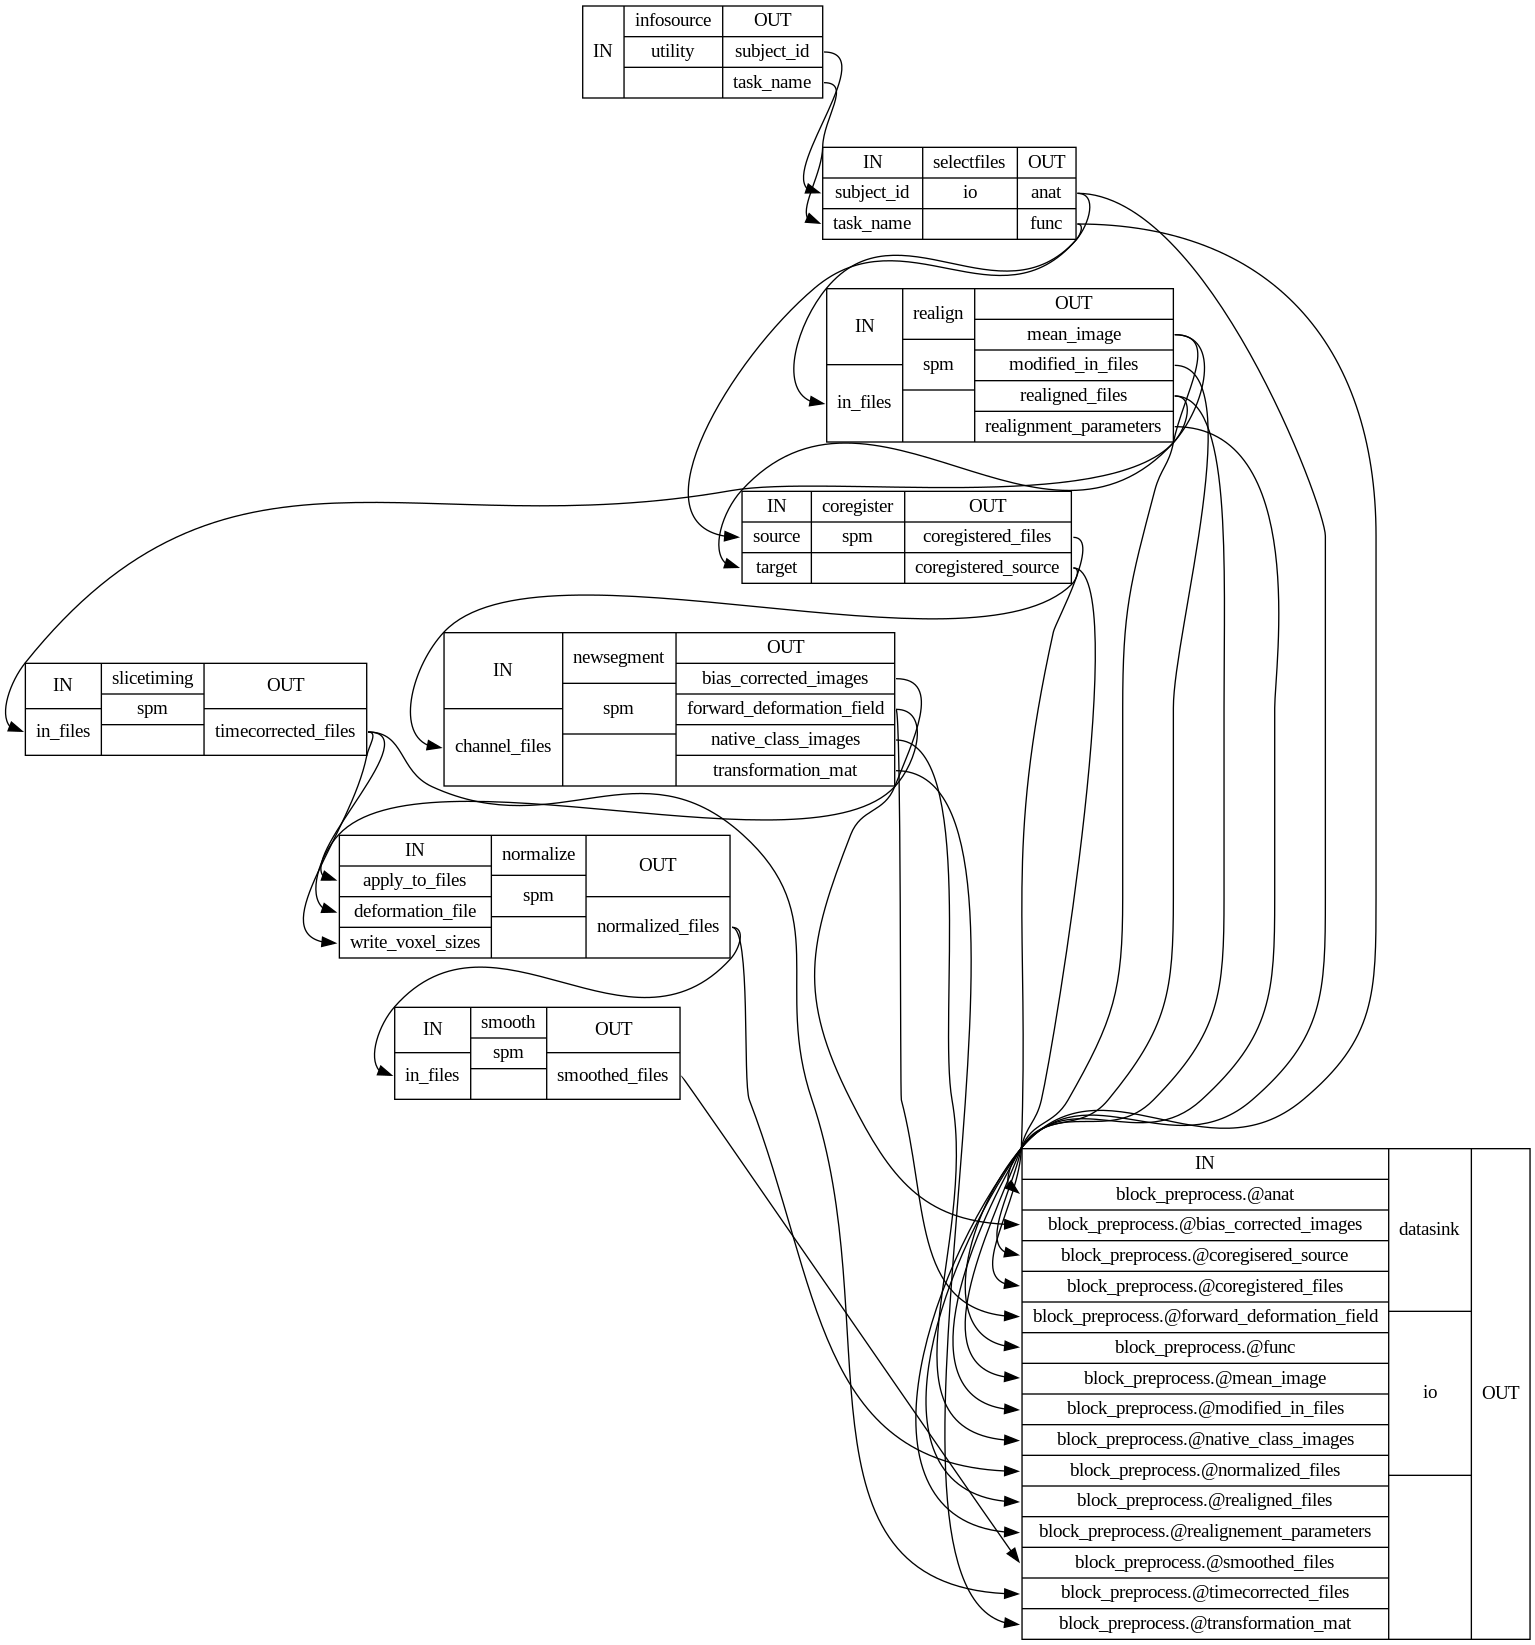

In [23]:
Image(filename=os.path.join(block_preprocess.base_dir, 'nipype_block_preprocess', 'flat_block_detailed.png'))

In [24]:
block_preprocess.run('MultiProc', plugin_args={'n_procs': 4})

240523-17:17:41,989 nipype.workflow INFO:
	 Workflow nipype_block_preprocess settings: ['check', 'execution', 'logging', 'monitoring']
240523-17:17:41,996 nipype.workflow INFO:
	 Running serially.
240523-17:17:41,997 nipype.workflow INFO:
	 [Node] Setting-up "nipype_block_preprocess.selectfiles" in "/home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/_subject_id_01_task_name_auditory/selectfiles".
240523-17:17:41,998 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
240523-17:17:42,0 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.000444s.
240523-17:17:42,1 nipype.workflow INFO:
	 [Node] Setting-up "nipype_block_preprocess.realign" in "/home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/_subject_id_01_task_name_auditory/realign".
240523-17:17:42,17 nipype.workflow INFO:
	 [Node] Executing "realign" <nipype.interfaces.spm.preprocess.Realign>


stty: 'standard input': Inappropriate ioctl for device


240523-17:18:11,323 nipype.workflow INFO:
	 [Node] Finished "realign", elapsed time 23.69865s.
240523-17:18:11,334 nipype.workflow INFO:
	 [Node] Setting-up "nipype_block_preprocess.slicetiming" in "/home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/_subject_id_01_task_name_auditory/slicetiming".
240523-17:18:11,338 nipype.workflow INFO:
	 [Node] Executing "slicetiming" <nipype.interfaces.spm.preprocess.SliceTiming>


stty: 'standard input': Inappropriate ioctl for device


240523-17:18:23,488 nipype.workflow INFO:
	 [Node] Finished "slicetiming", elapsed time 12.149584s.
240523-17:18:23,490 nipype.workflow INFO:
	 [Node] Setting-up "nipype_block_preprocess.coregister" in "/home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/_subject_id_01_task_name_auditory/coregister".
240523-17:18:23,495 nipype.workflow INFO:
	 [Node] Executing "coregister" <nipype.interfaces.spm.preprocess.Coregister>


stty: 'standard input': Inappropriate ioctl for device


240523-17:18:35,89 nipype.workflow INFO:
	 [Node] Finished "coregister", elapsed time 11.593045s.
240523-17:18:35,91 nipype.workflow INFO:
	 [Node] Setting-up "nipype_block_preprocess.newsegment" in "/home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/_subject_id_01_task_name_auditory/newsegment".
240523-17:18:35,95 nipype.workflow INFO:
	 [Node] Executing "newsegment" <nipype.interfaces.spm.preprocess.NewSegment>


stty: 'standard input': Inappropriate ioctl for device


240523-17:19:25,713 nipype.workflow INFO:
	 [Node] Finished "newsegment", elapsed time 50.616944s.
240523-17:19:25,726 nipype.workflow INFO:
	 [Node] Setting-up "nipype_block_preprocess.normalize" in "/home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/_subject_id_01_task_name_auditory/normalize".
240523-17:19:25,760 nipype.workflow INFO:
	 [Node] Executing "normalize" <nipype.interfaces.spm.preprocess.Normalize12>


stty: 'standard input': Inappropriate ioctl for device


240523-17:19:40,19 nipype.workflow INFO:
	 [Node] Finished "normalize", elapsed time 14.257569s.
240523-17:19:40,26 nipype.workflow INFO:
	 [Node] Setting-up "nipype_block_preprocess.smooth" in "/home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/_subject_id_01_task_name_auditory/smooth".
240523-17:19:40,27 nipype.workflow INFO:
	 [Node] Executing "smooth" <nipype.interfaces.spm.preprocess.Smooth>


stty: 'standard input': Inappropriate ioctl for device


240523-17:19:51,474 nipype.workflow INFO:
	 [Node] Finished "smooth", elapsed time 11.446256s.
240523-17:19:51,477 nipype.workflow INFO:
	 [Node] Setting-up "nipype_block_preprocess.datasink" in "/home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/_subject_id_01_task_name_auditory/datasink".
240523-17:19:51,483 nipype.workflow INFO:
	 [Node] Executing "datasink" <nipype.interfaces.io.DataSink>
240523-17:19:51,485 nipype.workflow INFO:
	 [Node] Finished "datasink", elapsed time 0.001612s.


stty: 'standard input': Inappropriate ioctl for device
